# Compute Rt for Haredim cities (Bnei-Brak, Elad, Modiin-Ilit, Beitar-Ilit)

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-p9ld1_b2 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
dfcit = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False, cities=True)
bb = ['6100', '3780', '3797', '1309', '1137']
model_bb = dfcit.loc[bb].groupby('date').sum()
gmbb = GenerativeModel(bb, model_bb, buffer_days = 10, delay=2, sigma=0.07)
gmbb.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1352 seconds.


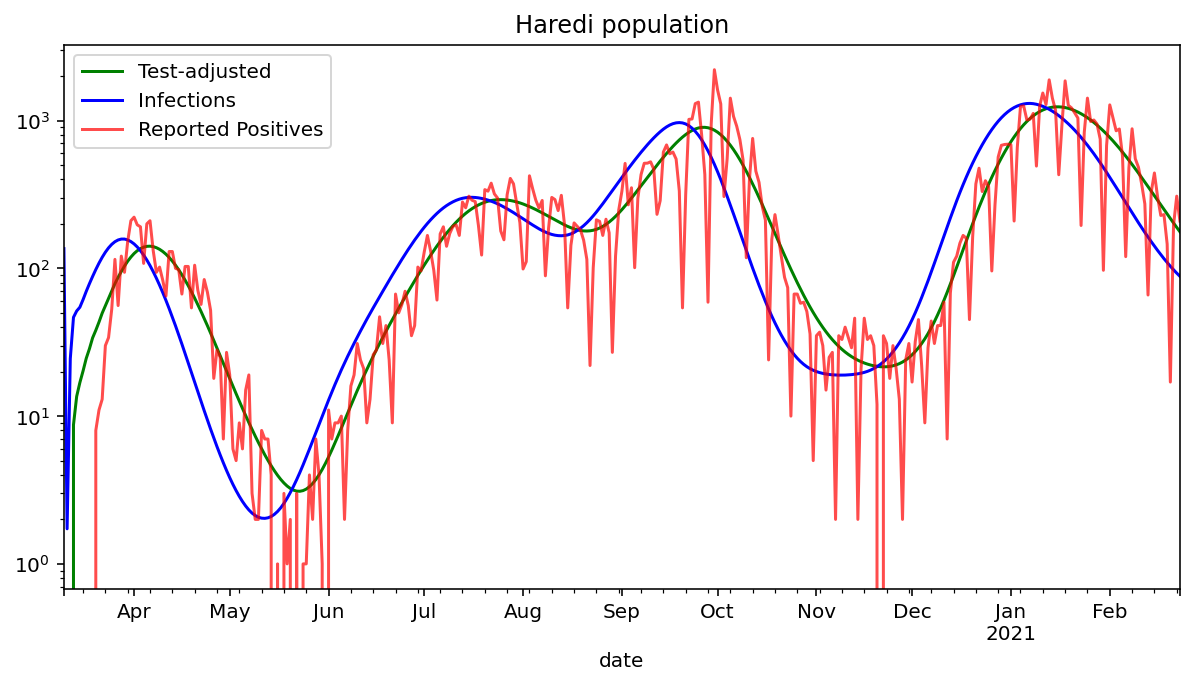

In [3]:
resultbb = summarize_inference_data(gmbb.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Haredi population")
resultbb.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultbb.infections.plot(c="b", label="Infections")
gmbb.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

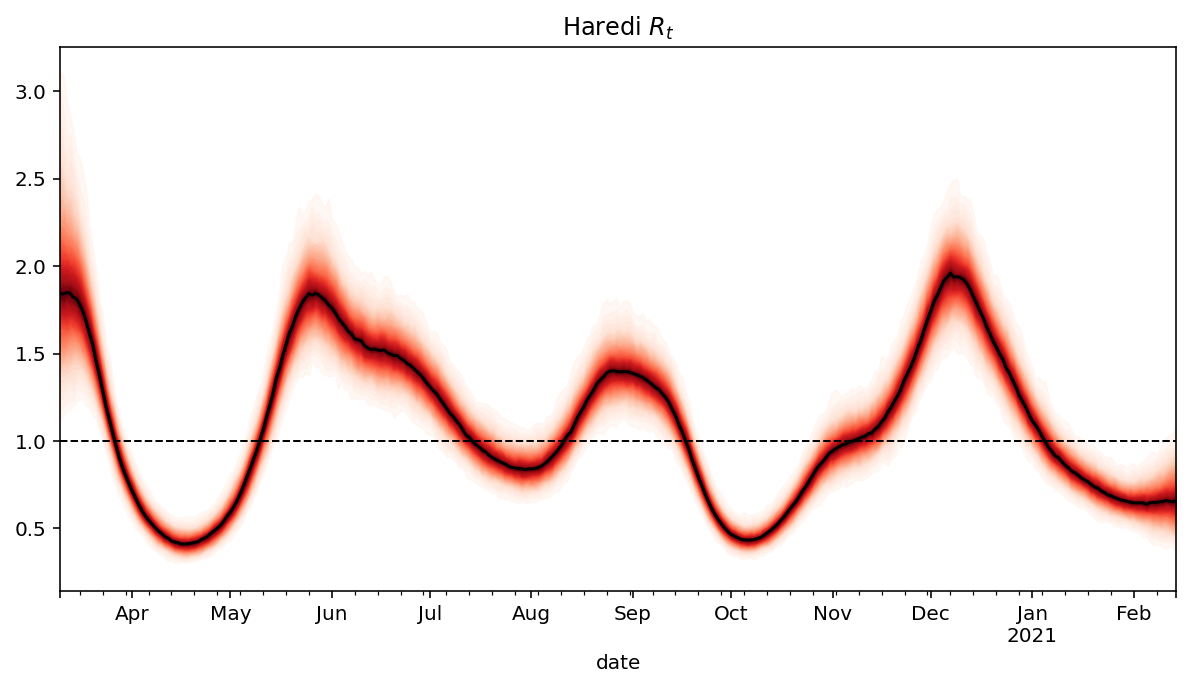

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Haredi $R_t$")
samples = gmbb.trace['r_t']
x=resultbb.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultbb["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [5]:
resultbb.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-26,1.350614,1.347574,1.155465,1.530162,869.248749,413.547799,96.0,96.0,500000
2020-12-27,1.310859,1.309864,1.121861,1.469916,929.840254,459.265415,268.0,268.0,500000
2020-12-28,1.271643,1.261115,1.113361,1.444732,988.682909,507.538788,566.0,566.0,500000
2020-12-29,1.233486,1.228092,1.070366,1.400130,1044.835728,558.091201,680.0,680.0,500000
2020-12-30,1.196144,1.193860,1.026394,1.357182,1097.385282,610.565798,689.0,689.0,500000
2020-12-31,1.156517,1.152814,0.979055,1.287913,1145.516415,664.524132,692.0,692.0,500000
2021-01-01,1.123148,1.115852,0.966923,1.276018,1188.460747,719.449080,686.0,686.0,500000
2021-01-02,1.090691,1.091604,0.946841,1.235788,1225.140300,774.753312,209.0,209.0,500000
2021-01-03,1.063078,1.062362,0.920467,1.205086,1255.071907,829.796958,659.0,659.0,500000


# General population

In [6]:
gn = ['5000', '8400', '8300', '1139', '2800', '9000', '2600', '6500', '6600', '6200', '9500']
model_gn = dfcit.loc[gn].groupby('date').sum()
gmgn = GenerativeModel(gn, model_gn, buffer_days = 10, delay=2, sigma=0.07)
gmgn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1494 seconds.


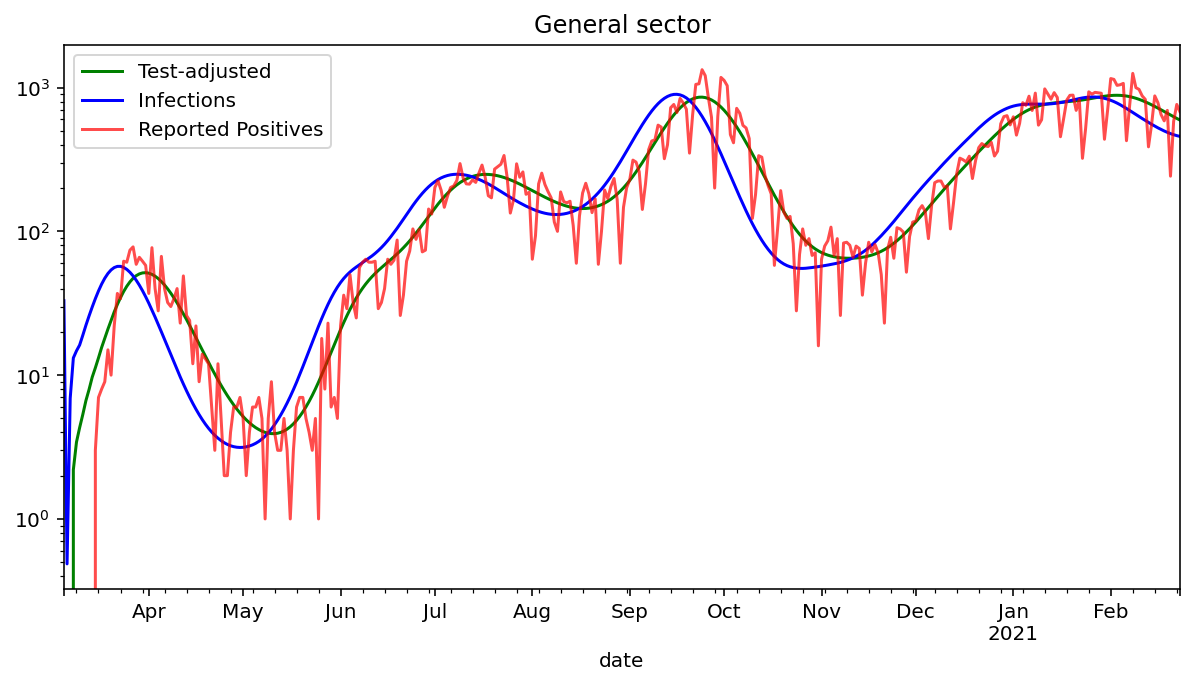

In [7]:
resultgn = summarize_inference_data(gmgn.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("General sector")
resultgn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultgn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgn.infections.plot(c="b", label="Infections")
gmgn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmgn.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

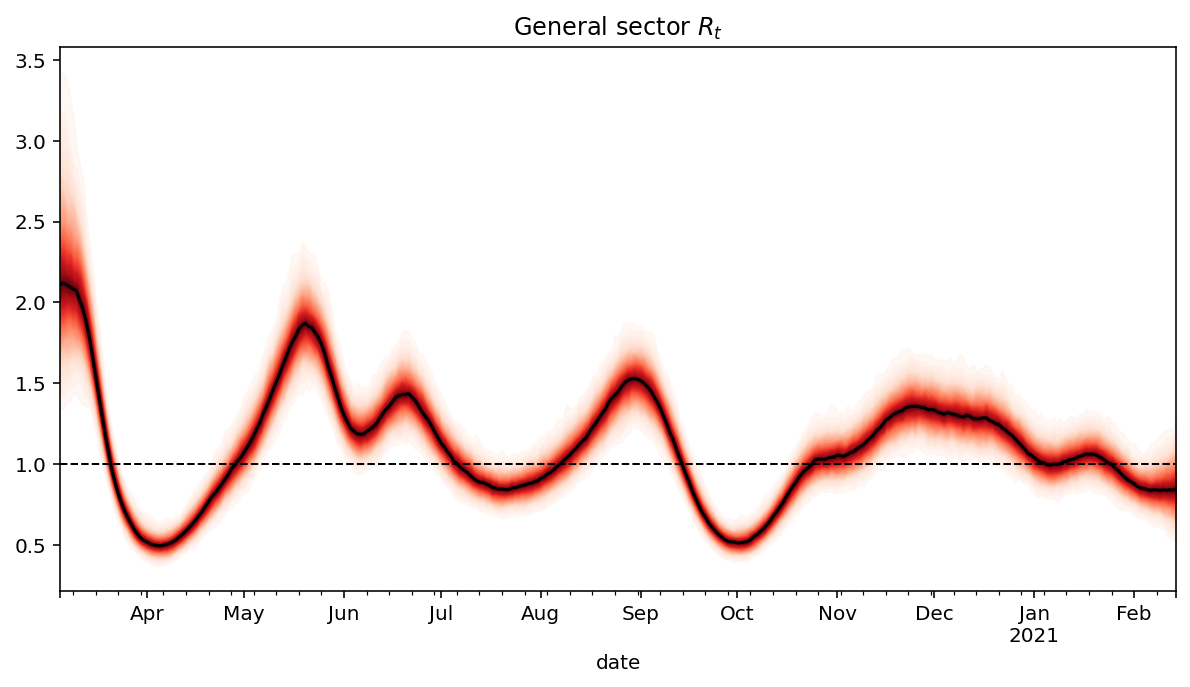

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"General sector $R_t$")
samples = gmgn.trace['r_t']
x=resultgn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultgn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [9]:
resultgn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-26,1.155853,1.157984,1.007106,1.291783,642.339621,461.172800,334.0,334.0,1100000
2020-12-27,1.140484,1.135613,1.005933,1.300650,663.722645,483.946913,361.0,361.0,1100000
2020-12-28,1.120206,1.114510,0.962469,1.250520,683.357531,507.184550,560.0,560.0,1100000
2020-12-29,1.100533,1.093037,0.973227,1.256327,701.375858,530.718024,628.0,628.0,1100000
2020-12-30,1.078260,1.066748,0.946878,1.215678,717.633499,554.335896,638.0,638.0,1100000
2020-12-31,1.060517,1.056316,0.923596,1.185886,731.684193,577.794644,550.0,550.0,1100000
2021-01-01,1.041540,1.039687,0.910250,1.168423,743.138415,600.858993,626.0,626.0,1100000
2021-01-02,1.028521,1.022464,0.894691,1.149963,752.047910,623.306635,467.0,467.0,1100000
2021-01-03,1.018500,1.010454,0.900081,1.166114,758.553062,644.905875,563.0,563.0,1100000


# Arab cities

In [10]:
ar = ['472', '2710', '6000', '2730', '2720', '8900', '509', '634', '7300', '7500', '531', '637', '638', '543', '8800']
model_ar = dfcit.loc[ar].groupby('date').sum()
gmar = GenerativeModel(ar, model_ar, buffer_days = 10, delay=2, sigma=0.07)
gmar.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1428 seconds.


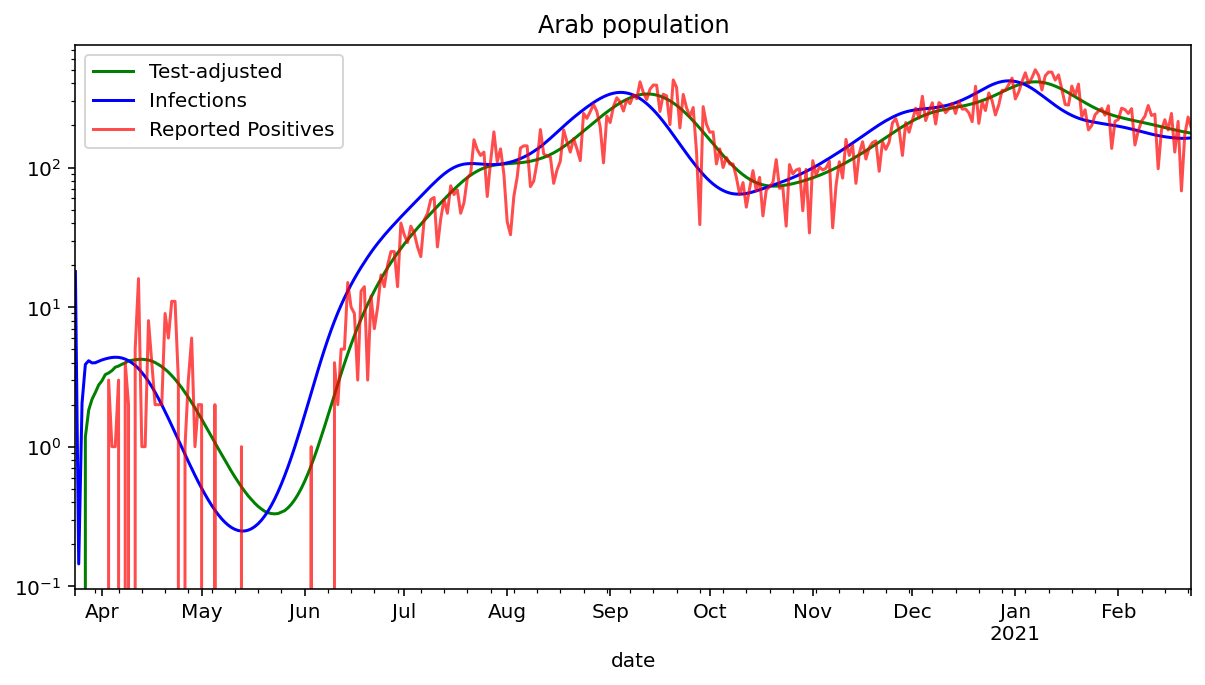

In [11]:
resultar = summarize_inference_data(gmar.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Arab population")
resultar.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultar.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultar.infections.plot(c="b", label="Infections")
gmar.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

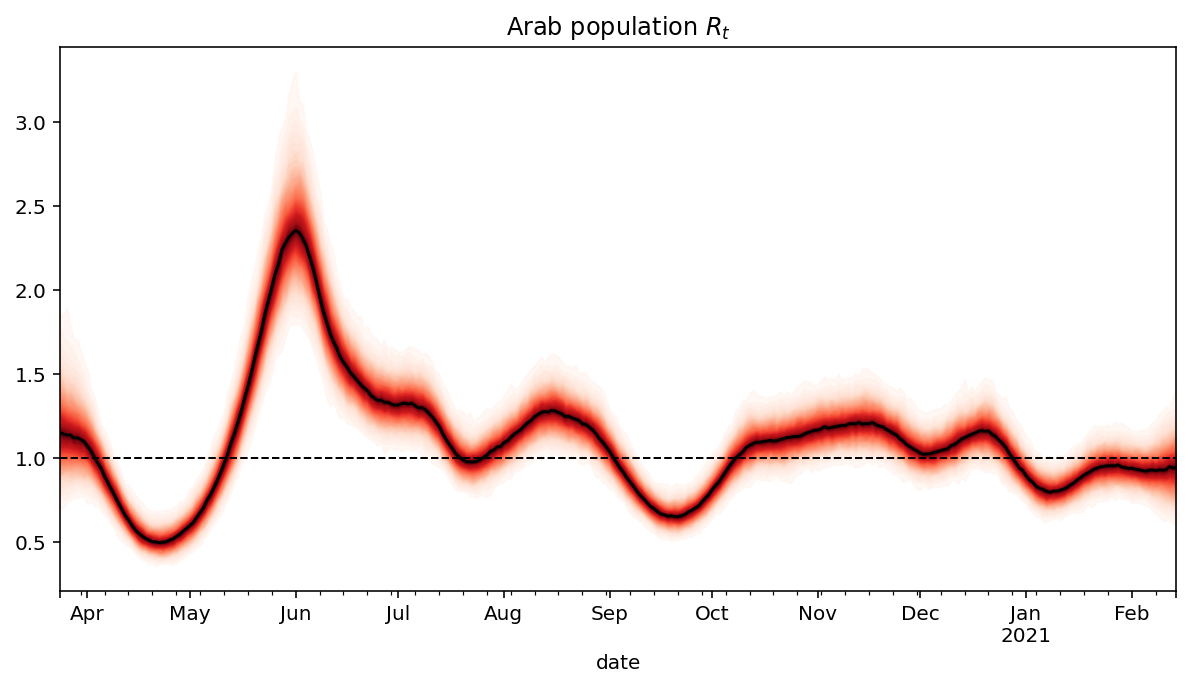

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Arab population $R_t$")
samples = gmar.trace['r_t']
x=resultar.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultar["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [13]:
resultar.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-26,1.067355,1.066461,0.926527,1.196320,400.696658,330.236562,238.0,238.0,1500000
2020-12-27,1.035126,1.032288,0.910002,1.171301,407.831016,338.855719,281.0,281.0,1500000
2020-12-28,1.007004,1.001948,0.879432,1.135723,413.271933,347.857603,357.0,357.0,1500000
2020-12-29,0.980322,0.973741,0.845990,1.101080,416.693173,357.063968,358.0,358.0,1500000
2020-12-30,0.952376,0.943524,0.833357,1.058536,417.829542,366.259619,393.0,393.0,1500000
2020-12-31,0.928176,0.928488,0.793232,1.025761,416.753476,375.210813,437.0,437.0,1500000
2021-01-01,0.901260,0.897679,0.785495,1.005372,413.488664,383.668821,310.0,310.0,1500000
2021-01-02,0.879647,0.873087,0.758216,0.974557,408.123134,391.374297,347.0,347.0,1500000
2021-01-03,0.857274,0.856763,0.755146,0.977189,400.738363,398.082688,413.0,413.0,1500000


In [14]:
jr = ['3000']
model_jr = dfcit.loc[jr].groupby('date').sum()
gmjr = GenerativeModel(jr, model_jr, buffer_days = 10, delay=2)
gmjr.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1537 seconds.


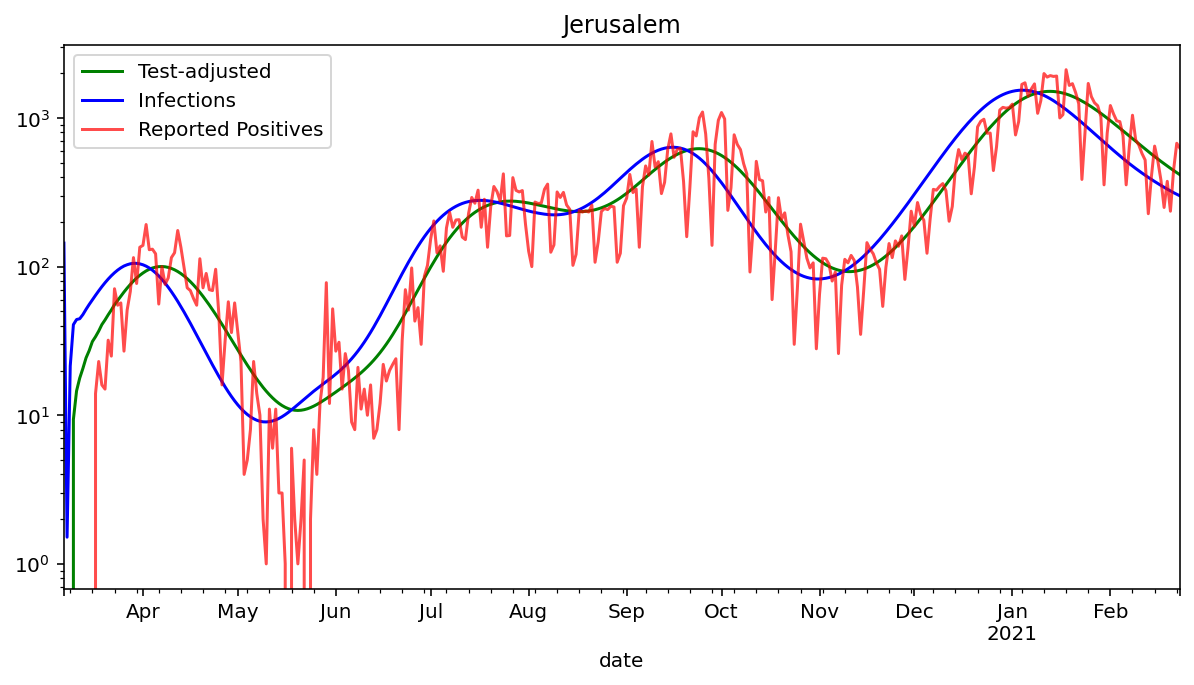

In [15]:
resultjr = summarize_inference_data(gmjr.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Jerusalem")
resultjr.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultjr.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultjr.infections.plot(c="b", label="Infections")
gmjr.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmjr.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

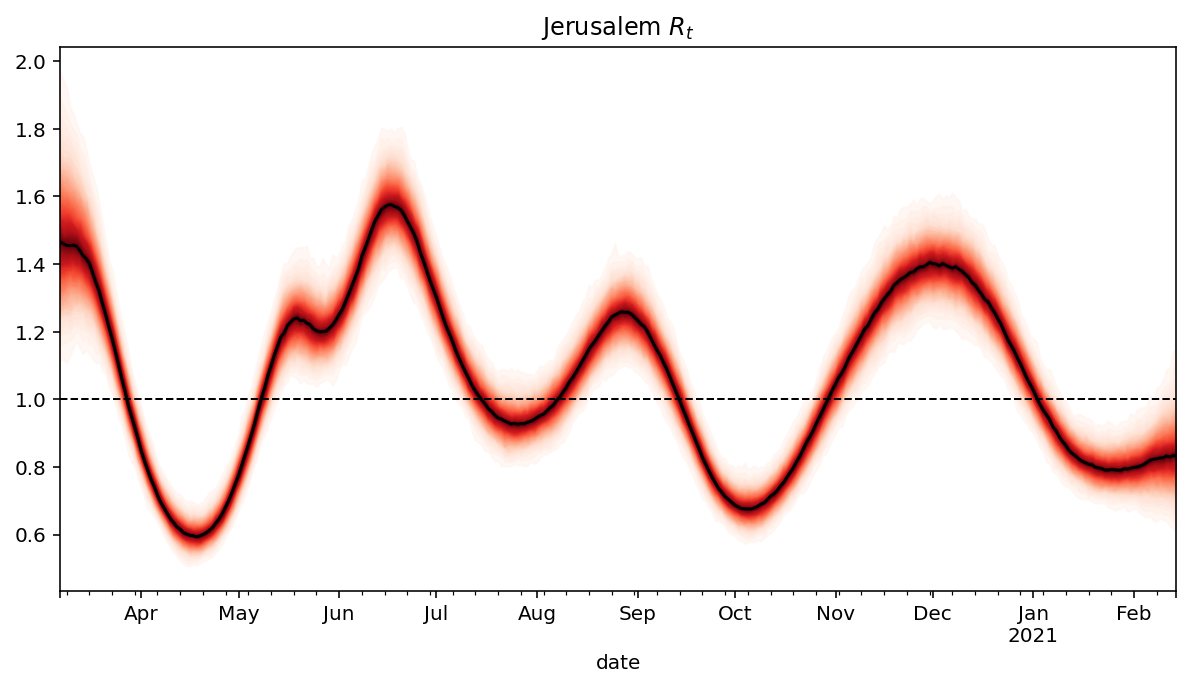

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Jerusalem $R_t$")
samples = gmjr.trace['r_t']
x=resultjr.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultjr["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [17]:
resultjr.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-26,1.146667,1.143753,1.064739,1.236346,1322.174972,915.097844,443.0,443.0,100000
2020-12-27,1.124945,1.122875,1.031119,1.201629,1363.690929,963.734655,643.0,643.0,100000
2020-12-28,1.105035,1.104465,1.021893,1.190653,1401.964040,1012.723247,1131.0,1131.0,100000
2020-12-29,1.085171,1.083141,1.009687,1.169041,1436.353685,1061.682343,1179.0,1179.0,100000
2020-12-30,1.064147,1.061056,0.991857,1.147318,1466.227600,1110.189052,1165.0,1165.0,100000
2020-12-31,1.046610,1.044192,0.958783,1.113649,1491.351285,1157.821140,1175.0,1175.0,100000
2021-01-01,1.025987,1.025719,0.941638,1.094770,1511.304148,1204.147180,1240.0,1240.0,100000
2021-01-02,1.005945,1.004238,0.922852,1.071845,1526.077317,1248.714760,769.0,769.0,100000
2021-01-03,0.987418,0.984900,0.914108,1.062032,1535.448838,1291.071924,947.0,947.0,100000


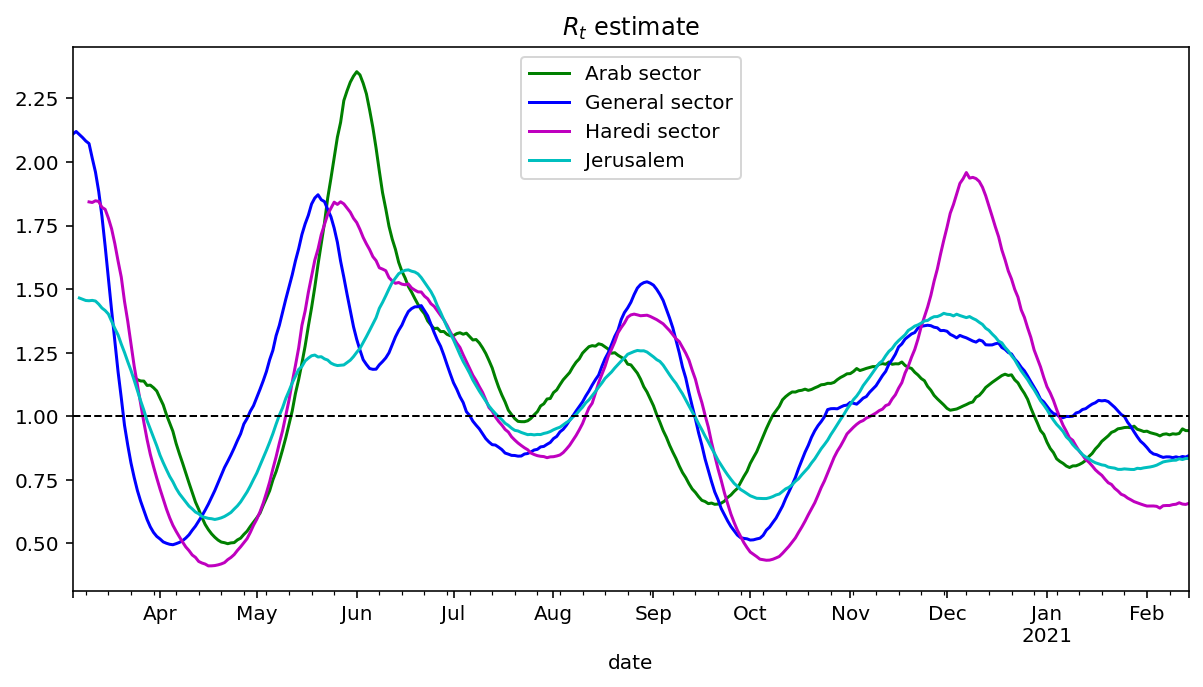

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultar["median"].plot(c="g", ls='-', label="Arab sector")
resultgn["median"].plot(c="b", ls='-', label="General sector")
resultbb["median"].plot(c="m", ls='-', label="Haredi sector")
resultjr["median"].plot(c="c", ls='-', label="Jerusalem")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [19]:
resultar.to_csv("results_arab_cities_out.csv")
resultbb.to_csv("results_haredi_cities_out.csv")
resultgn.to_csv("results_general_cities_out.csv")
resultjr.to_csv("results_jerusalem_out.csv")

{'3726', '3618', '3604', '3725', '3650', '3563'}


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1549 seconds.


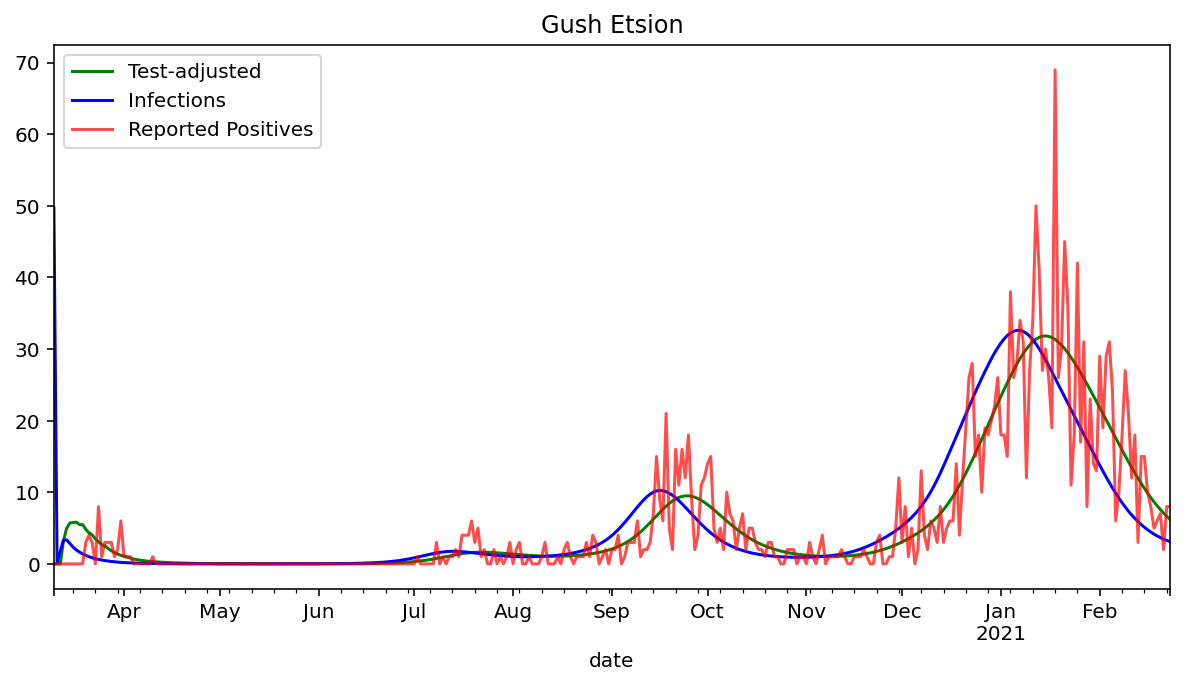

In [20]:
gush = ["3604", "3618", "3650", "3794", "3603", "3488", "3561", "3653", "3725", "3726", "1982", "1981", "3781", "3602", "3563"]
gush = set(gush) & set(list(dfcit.index.unique(0)))
print(gush)
model_gs = dfcit.loc[gush].groupby('date').sum()
gmgs = GenerativeModel(gush, model_gs, buffer_days = 10, delay=2, sigma=0.07)
gmgs.sample()

resultgs = summarize_inference_data(gmgs.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Gush Etsion")
resultgs.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgs.infections.plot(c="b", label="Infections")
gmgs.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
#plt.yscale("log")
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Gush Etsion $R_t$")
samples = gmgs.trace['r_t']
x=resultgs.index
colmap = plt.get_cmap("Reds")
ax.fill_between(x, resultgs["upper_80"], resultgs["lower_80"], color=colmap(50), alpha=.8)
resultgs["median"].plot(c=colmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
